In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import sys
import sdeint
import torch
from neurosim.models.ssr import StateSpaceRealization as SSR
from dca_research.lqg import LQGComponentsAnalysis as LQGCA
from tqdm import tqdm

/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
sys.path.append('/home/akumar/nse/neural_control')

In [5]:
from soc import stabilize, gen_init_W, stabilize_discrete, comm_mat

In [7]:
from utils import apply_df_filters

### Continuous time optimization

In [21]:
np.linspace(0.75, 10, 25)

array([ 0.75      ,  1.13541667,  1.52083333,  1.90625   ,  2.29166667,
        2.67708333,  3.0625    ,  3.44791667,  3.83333333,  4.21875   ,
        4.60416667,  4.98958333,  5.375     ,  5.76041667,  6.14583333,
        6.53125   ,  6.91666667,  7.30208333,  7.6875    ,  8.07291667,
        8.45833333,  8.84375   ,  9.22916667,  9.61458333, 10.        ])

In [6]:
reps = 20
inner_reps = 10
M = 100
p = 0.25
gamma = np.array([2])
R = np.linspace(0.75, 10, 25)
dt = 1

In [7]:
# In order to illustrate the desired effect, we vary along several parameters. (1) is the degree to which connections within and between blocks are asymmetric.
# (2) gamma, R
# 

phi = np.zeros((reps, gamma.size, R.size, inner_reps))
scores = np.zeros((reps, gamma.size, R.size, inner_reps))

nn = np.zeros((reps, gamma.size, R.size, 2))

for rep in range(reps):
    for i, g in enumerate(gamma):
        for j, r in tqdm(enumerate(R)):
            A = gen_init_W(M, p, g, r, -1)
            eig = np.linalg.eigvals(A)
            if np.max(np.real(eig)) >= 0:
                A = stabilize(A)
                eig = np.linalg.eigvals(A)

            assert(np.max(np.real(eig)) < 0)

            # Scale down
            A /= 10

            # Generate data using this model; both linear and nonlinear activation functions
            
            # In the linear case, we can calculate the autocorrelation matrices exactly, so might as well do that for now.
            
            # Stability optimize the spectral radius

            # # Use a Tustin discretization of the state space parameter
            B = np.eye(A.shape[0])
            C = np.eye(A.shape[0])


            sigma = 2/dt
            #Ad = (sigma * np.eye(A.shape[0]) + A) @ np.linalg.inv(sigma * np.eye(A.shape[0]) - A)
            #Ad = A + np.eye(A.shape[0])
            #Bd = np.sqrt(2 * sigma) * np.linalg.inv(sigma * np.eye(A.shape[0]) - A) @ B
            #Cd = np.sqrt(2 * sigma) * C @ np.linalg.inv(sigma * np.eye(A.shape[0]) - A)

            # assert(np.max(np.abs(np.linalg.eigvals(Ad))) < 1)

            Bd = B
            Cd = C

            nn[rep, i, j, 0] = np.linalg.norm(A @ A.T - A.T @ A)

            # Solve for the exact covarinace function and evaluate it at intervals of dt
            Pi = scipy.linalg.solve_continuous_lyapunov(A, -np.eye(A.shape[0]))
            t_ = [j * dt for j in range(10)]
            cross_covs = [scipy.linalg.expm(tau * A) @ Pi for tau in t_]

            d = 6
            # ssr = SSR(A=Ad, B=Bd, C=Cd)
            # cross_covs = ssr.autocorrelation(10)
            cross_covs_rev = [np.linalg.inv(cross_covs[0]) @ c.T @ np.linalg.inv(cross_covs[0]) for c in cross_covs]

            cross_covs = torch.tensor(cross_covs)
            cross_covs_rev = torch.tensor(cross_covs_rev)

            e, Upca = np.linalg.eig(cross_covs[0])
            eigorder = np.argsort(e)[::-1]
            Upca = Upca[:, eigorder][:, 0:d]

            lqgmodel = LQGCA(d=d, T=4)
            lqgmodel.cross_covs = cross_covs
            lqgmodel.cross_covs_rev = cross_covs_rev

            for k in range(inner_reps):
                coef_, score = lqgmodel._fit_projection()
                phi[rep, i, j, k] = np.mean(scipy.linalg.subspace_angles(Upca, coef_))
                scores[rep, i, j, k] = score            
            

0it [00:00, ?it/s]/tmp/ipykernel_26310/687149710.py:58: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  cross_covs = torch.tensor(cross_covs)
25it [01:58,  4.75s/it]
25it [01:59,  4.76s/it]
25it [01:58,  4.72s/it]
25it [01:59,  4.79s/it]
25it [01:58,  4.74s/it]
25it [01:58,  4.75s/it]
25it [01:59,  4.78s/it]
25it [01:59,  4.80s/it]
25it [01:57,  4.70s/it]
25it [01:58,  4.75s/it]
25it [02:00,  4.80s/it]
25it [01:59,  4.76s/it]
25it [01:58,  4.75s/it]
25it [01:58,  4.73s/it]
25it [01:58,  4.72s/it]
25it [01:57,  4.70s/it]
25it [02:05,  5.02s/it]
25it [02:05,  5.02s/it]
25it [02:09,  5.18s/it]
25it [02:09,  5.16s/it]


In [5]:
import pickle

In [6]:
# with open('soc_sim.pkl', 'wb') as f:
#     f.write(pickle.dumps(phi))
#     f.write(pickle.dumps(nn))
#     f.write(pickle.dumps(scores))

with open('soc_sim.pkl', 'rb') as f:
    phi = pickle.load(f)
    nn = pickle.load(f)
    scores = pickle.load(f)

In [11]:
phi.shape

(20, 1, 25, 10)

Text(0.5, 0, 'Increasing Non-normality $\\to$')

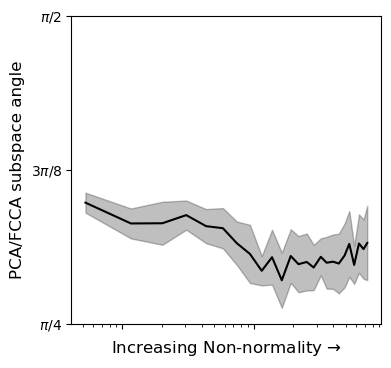

In [12]:
fig, ax = plt.subplots(figsize=(4, 4)h)

gidx = 0
ax.plot(np.mean(nn[..., 0], axis=0)[gidx, :], np.mean(np.mean(phi, axis=-1), axis=0)[gidx, :], color='k')
ax.fill_between(np.mean(nn[..., 0], axis=0)[gidx, :], np.mean(np.mean(phi, axis=-1), axis=0)[gidx, :] - np.std(np.mean(phi, axis=-1), axis=0)[gidx, :], np.mean(np.mean(phi, axis=-1), axis=0)[gidx, :] + np.std(np.mean(phi, axis=-1), axis=0)[gidx, :], alpha=0.25, color='k')
ax.set_xscale('log')

ax.set_ylim([np.pi/4, np.pi/2])
ax.set_yticks([np.pi/4, 3 * np.pi/8, np.pi/2])
ax.set_yticklabels([r'$\pi/4$', r'$3\pi/8$', r'$\pi/2$'])
ax.set_xticklabels([])

ax.set_ylabel('PCA/FCCA subspace angle', fontsize=12)
ax.set_xlabel('Increasing Non-normality ' + r'$\to$', fontsize=12)
#fig.savefig('/home/akumar/nse/neural_control/figs/loco_indy_merge/soc_ssa.pdf', bbox_inches='tight', pad_inches=0)

In [ ]:
# Might be something here if we play with the parameters a bit more

In [62]:
eigvals = np.zeros((len(gamma), len(R), 2 * M)).astype(np.complex)
W = []
for i, g in enumerate(gamma):
    W.append([])
    for j, r in tqdm(enumerate(R)):
        A = gen_init_W(M, p, g, r, -1)
        eig = np.linalg.eigvals(A)
        if np.max(np.real(eig)) >= 0:
            A = stabilize(A)
            eig = np.linalg.eigvals(A)

        eigvals[i, j, :] = eig
        # Scale down by a factor of 10 to match the empirical eigenvalue range
        W[i].append(A/10)

/tmp/ipykernel_8927/3579978348.py:1: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eigvals = np.zeros((len(gamma), len(R), 2 * M)).astype(np.complex)
25it [00:57,  2.30s/it]
25it [00:50,  2.01s/it]
25it [00:43,  1.72s/it]


In [63]:
# Calculate the associated pseudospectra
from pseudopy.nonnormal import NonnormalAuto
from pseudopy.normal import Normal

In [64]:
nn1 = NonnormalAuto(W[1][0], 1e-5, 1)

In [65]:
nn2 = NonnormalAuto(W[1][12], 1e-5, 1)

In [66]:
nn3 = NonnormalAuto(W[1][24], 1e-5, 1)

In [67]:
import pickle

In [68]:
with open('soc_pseudo2.pkl', 'wb') as f:
    f.write(pickle.dumps(nn1))
    f.write(pickle.dumps(nn2))
    f.write(pickle.dumps(nn3))

In [69]:
n1 = Normal(W[1][0])
n2 = Normal(W[1][12])
n3 = Normal(W[1][24])

In [70]:
nnobj = nn2
nobj = n2
A_ = W[1][0]

/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/pseudopy/normal.py:38: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  pseudospec = cascaded_union(circles)
/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/pseudopy/utils.py:40: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in obj:


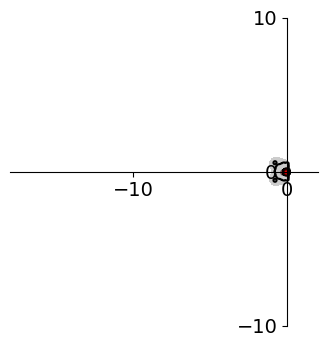

In [71]:
fig, ax = plt.subplots(figsize=(4, 4))

levels = [1e-6, 1e-1]

ax.set_aspect('equal')
ax.tricontourf(nnobj.triang, nnobj.vals, levels=levels, colors=['k'], alpha=0.2)
ax.scatter(np.real(np.linalg.eigvals(A_)), np.imag(np.linalg.eigvals(A_)), s=15, alpha=0.5, marker='o', edgecolor='k', color='r')
nn1 = NonnormalAuto(W[1][0], 1e-5, 1)
epsilons = list(np.sort(levels))
padepsilons = [epsilons[0]*0.9] + epsilons + [epsilons[-1]*1.1]
X = []
Y = []
Z = []
for epsilon in padepsilons:
    paths = nobj.contour_paths(epsilon)
    for path in paths:
        X += list(np.real(path.vertices[:-1]))
        Y += list(np.imag(path.vertices[:-1]))
        Z += [epsilon] * (len(path.vertices) - 1)
ax.tricontour(X, Y, Z, levels=[1e-1], colors='k')


# Add stability circle
# circle1 = plt.Circle((0, 0), 1, color='k', fill=False, linestyle='--')
# ax.add_patch(circle1)
# ax.set_ylabel('Im' + r'$(z)$', fontsize=14)
# ax.set_yticks([-1., -0.5, 0, 0.5, 1.])
# ax.set_xlabel('Re' + r'$(z)$', fontsize=14)
# ax.set_xticks([-1., -0.5, 0, 0.5, 1.])

ax.set_xlim([-18, 2])
ax.set_ylim([-10, 10])
#ax.xaxis.tick_top()
#ax.xaxis.set_label_position('top')
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xticks([-10, 0])
ax.set_yticks([-10, 0, 10])

ax.tick_params(axis='both', labelsize=14)
fig.savefig('/home/akumar/nse/neural_control/figs/loco_indy_merge/soc1b.pdf', bbox_inches='tight', pad_inches=0)

In [1]:
# Plot representative examples from the start, middle, and end
fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(np.real(eigvals[0, 0, :]), np.imag(eigvals[0, 0, :]))
ax.scatter(np.real(eigvals[0, 12, :]), np.imag(eigvals[0, 12, :]))
ax.scatter(np.real(eigvals[0, 24, :]), np.imag(eigvals[0, 12, :]))

NameError: name 'plt' is not defined

In [ ]:
# In a subsequent analysis, we then look at rotational dynamics found in each of the subspaces. This will then feed into an analysis of the one timestep problem and a more
# intuitive analysis of why one expects rotational dynamics to be feedback controllable

In [ ]:
# What about rank of the input?

In [ ]:
# (1) Verify that the W generation protocol adopted gives rise to the expected spectral radius

# (2) When simulating, figure out how to do time discretization. Key is to have time symmetric autocorrelation matrices in the case of interest

In [ ]:
# testing discrete stabilization

### Discrete time optimization

In [5]:
A = gen_init_W(20, 0.9, 1., 1.)
C = 1.01
n = A.shape[0]

alpha_e = C * np.max(np.abs(np.linalg.eigvals(A)))
P = scipy.linalg.solve_discrete_lyapunov(A/alpha_e, np.eye(n))
K = comm_mat(n, n)

# Note in the last term, we include a factor of alpha_e squared since we also pulled it out of the dA term
jac = np.linalg.inv(np.eye(n**2)- np.kron(A/alpha_e, A/alpha_e)) @ (np.kron(A/alpha_e**2 @ P, np.eye(n)) + np.kron(np.eye(n), A @ P/alpha_e**2) @ K)

grad = (np.eye(n).flatten().T @ jac).reshape((n, n), order='F')

In [6]:
inh_idx = np.argwhere(A < 0)

# Take the largest step size that still decreases the trace
eta = np.logspace(-8, -1, 50)
tr = np.zeros(eta.size)
for i in range(eta.size):
    Ap = np.zeros(A.shape)
    for idx in inh_idx:
        Ap[idx[0], idx[1]] = A[idx[0], idx[1]] - eta[i] * grad[idx[0], idx[1]]

    tr[i] = np.trace(scipy.linalg.solve_discrete_lyapunov(Ap/alpha_e, np.eye(n)))        

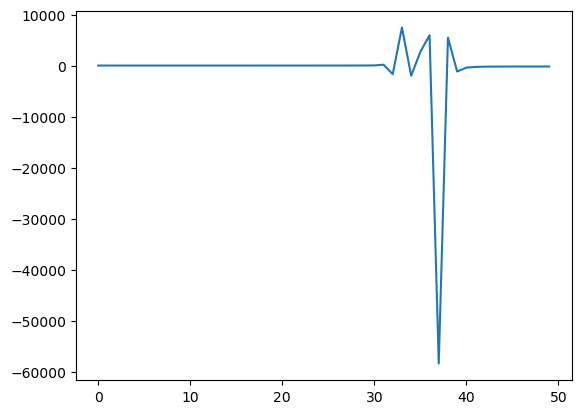

In [7]:
plt.plot(tr)

In [8]:
np.argmin(tr)

37

In [9]:
As = stabilize_discrete(A, C=1.01, max_iter=10000)

iter_:0, alpha:2.917998
iter_:1, alpha:42.467617
iter_:2, alpha:42.359033
iter_:3, alpha:42.250127
iter_:4, alpha:42.140893
iter_:5, alpha:42.031329
iter_:6, alpha:41.921431
iter_:7, alpha:41.811197
iter_:8, alpha:41.700623
iter_:9, alpha:41.589705
iter_:10, alpha:41.478439
iter_:11, alpha:41.366823
iter_:12, alpha:41.254853
iter_:13, alpha:41.142524
iter_:14, alpha:41.029833
iter_:15, alpha:40.916776
iter_:16, alpha:40.803350
iter_:17, alpha:40.689550
iter_:18, alpha:40.575372
iter_:19, alpha:40.460811
iter_:20, alpha:40.345865
iter_:21, alpha:40.230527
iter_:22, alpha:40.114795
iter_:23, alpha:39.998663
iter_:24, alpha:39.882126
iter_:25, alpha:39.765181
iter_:26, alpha:39.647822
iter_:27, alpha:39.530044
iter_:28, alpha:39.411843
iter_:29, alpha:39.293213
iter_:30, alpha:39.174149
iter_:31, alpha:39.054645
iter_:32, alpha:38.934697
iter_:33, alpha:38.814299
iter_:34, alpha:38.693444
iter_:35, alpha:38.572128
iter_:36, alpha:38.450344
iter_:37, alpha:38.328086
iter_:38, alpha:38.2053

array([2.50658475, 2.50658475, 2.20770785, 2.20770785, 1.71926116,
       1.71926116, 1.93377617, 1.78917436, 1.78917436, 1.38165686,
       1.10990205, 1.10990205, 0.65437574, 0.65437574, 1.04142551,
       1.04142551, 0.85808857, 0.85808857, 0.6634707 , 0.6634707 ])

In [43]:
np.abs(np.linalg.eigvals(As))

array([3.54030612, 3.54030612, 3.99675544, 2.09045241, 2.09045241,
       3.14381923, 3.14381923, 3.22119402, 3.22119402, 2.44224611,
       2.44224611, 2.65899812, 2.65899812, 2.68450991, 1.2233754 ,
       1.2233754 , 1.12239873, 1.7933493 , 1.7933493 , 1.71519929])

In [45]:
np.allclose(A, As)

True

### Rotational Content

In [8]:
from dca.methods_comparison import JPCA
import pdb

In [9]:
def gen_activity(tau, W, activ_func, sigma, T, h):

    # f
    def f_(x, t):
        return 1/tau * (-1 * np.eye(W.shape[0]) @ x + W @ activ_func(x))

    # G: linear i.i.d noise with sigma
    def g_(x, t):
        return sigma * np.eye(W.shape[0])

    # Generate random initial condition and then integrate over the desired time period
    tspace = np.linspace(0, T, int(T/h))
    
    x0 = np.random.normal(size=(W.shape[0],))

    return  sdeint.itoSRI2(f_, g_, x0, tspace)    

In [7]:
# In order to illustrate the desired effect, we vary along several parameters. (1) is the degree to which connections within and between blocks are asymmetric.
# (2) gamma, R
# 

reps = 1
inner_reps = 1
M = 100
p = 0.25
gamma = np.array([2])
R = np.linspace(0.75, 10, 25)
dt = 1

d = 6

phi = np.zeros((reps, gamma.size, R.size, inner_reps))
scores = np.zeros((reps, gamma.size, R.size, inner_reps))
nn = np.zeros((reps, gamma.size, R.size, 2))
jpca_eig = np.zeros((reps, gamma.size, R.size, inner_reps, 2))

for rep in range(reps):
    for i, g in enumerate(gamma):
        for j, r in tqdm(enumerate(R)):
            A = gen_init_W(M, p, g, r, -1)
            eig = np.linalg.eigvals(A)
            if np.max(np.real(eig)) >= 0:
                A = stabilize(A)
                eig = np.linalg.eigvals(A)

            assert(np.max(np.real(eig)) < 0)

            nn[rep, i, j, 0] = np.linalg.norm(A @ A.T - A.T @ A)

            # Solve for the exact covarinace function and evaluate it at intervals of dt
            Pi = scipy.linalg.solve_chontinuous_lyapunov(A, -np.eye(A.shape[0]))
            t_ = [j * dt for j in range(10)]
            cross_covs = [scipy.linalg.expm(tau * A) @ Pi for tau in t_]

            cross_covs_rev = [np.linalg.inv(cross_covs[0]) @ c.T @ np.linalg.inv(cross_covs[0]) for c in cross_covs]

            cross_covs = torch.tensor(cross_covs)
            cross_covs_rev = torch.tensor(cross_covs_rev)

            e, Upca = np.linalg.eig(cross_covs[0])
            eigorder = np.argsort(e)[::-1]
            Upca = Upca[:, eigorder][:, 0:d]

            lqgmodel = LQGCA(d=d, T=4)
            lqgmodel.cross_covs = cross_covs
            lqgmodel.cross_covs_rev = cross_covs_rev
            # Simulate from the model, apply projection, and then fit jPCA

            x = gen_activity(1, A, lambda x: x, 1, 100, 1e-2)   

            if np.any(np.isnan(x)):
                pdb.set_trace()         

            for k in range(inner_reps):
                coef_, score = lqgmodel._fit_projection()

                phi[rep, i, j, k] = np.mean(scipy.linalg.subspace_angles(Upca, coef_))
                scores[rep, i, j, k] = score            

                xfca = x @ coef_
                xpca = x @ Upca

                jpca = JPCA(n_components=d, mean_subtract=False)
                jpca.fit(xfca[np.newaxis, :])
                jpca_eig[rep, i, j, k, 0] = np.sum(np.abs(jpca.eigen_vals_))

                jpca = JPCA(n_components=d, mean_subtract=False)
                jpca.fit(xpca[np.newaxis, :])
                jpca_eig[rep, i, j, k, 1] = np.sum(np.abs(jpca.eigen_vals_))



0it [00:00, ?it/s]/tmp/ipykernel_15378/4218481164.py:40: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  cross_covs = torch.tensor(cross_covs)
25it [35:07, 84.29s/it]


In [25]:
jpca_eig.shape

(1, 1, 25, 1, 2)

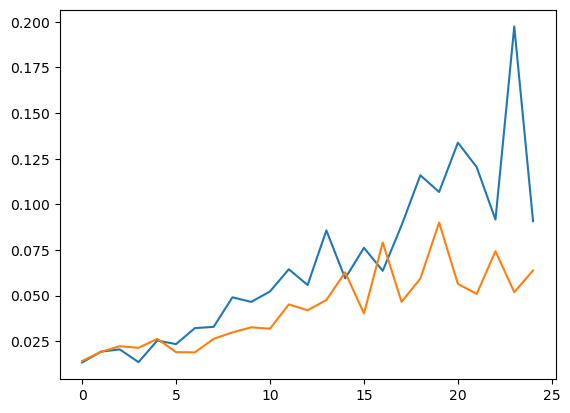

In [8]:
fig, ax = plt.subplots()
ax.plot(jpca_eig[0, 0, :, 0, 0])
ax.plot(jpca_eig[0, 0, :, 0, 1])
#fig.savefig('tmp.png')

In [26]:
jpca_eig[0, 0, :, 0, 0]

array([0.12577024, 0.13654404, 0.11379131, 0.1365949 , 0.14981208,
       0.10642807, 0.09959917, 0.10639049, 0.09071179, 0.08558685,
       0.08716043, 0.06633713, 0.07433853, 0.08041645, 0.08654922,
       0.0602669 , 0.05279587, 0.03789738, 0.02428842, 0.02033318,
       0.02494458, 0.01927813, 0.01613659, 0.01069635, 0.00725856])

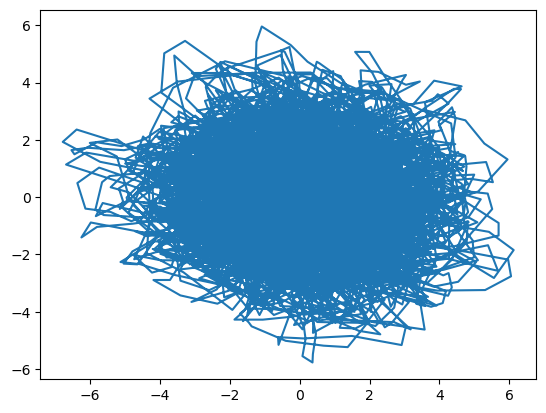

In [12]:
plt.plot(xpca[:, 0], xpca[:, 1])

In [17]:
jpcamodel = JPCA(n_components=6, mean_subtract=False)
jpcamodel.fit(xpca[np.newaxis, :])

In [20]:
np.sum(np.abs(jpcamodel.eigen_vals_))

0.9804527197245242

In [23]:
jpca_eig[0, ..., 0, :]

array([[[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]]])

In [1]:
# Consolidate run that was done on NERSC and plot

In [14]:
from glob import glob
import pickle
from pickle import UnpicklingError
import pandas as pd
import pdb

In [15]:
fls = glob('/mnt/Secondary/data/soc_jpca/*.pkl')

In [16]:
rl = []
    
for fl in fls:
    with open(fl, 'rb') as f:
        while True:
            try:
                task = pickle.load(f)
                A = pickle.load(f)
                phi = pickle.load(f)
                scores = pickle.load(f)
                nn = pickle.load(f)
                jpca_eig = pickle.load(f)

                rep, inner_rep, R = task
                r = {}
                r['rep'] = int(rep)
                r['irep'] = int(inner_rep)
                r['R'] = R
                r['A'] = A
                r['phi'] = phi
                r['scores'] = scores
                r['nn'] = nn
                r['jpca_eig'] = jpca_eig
                rl.append(r)
            except (EOFError, UnpicklingError):
                break

In [17]:
# verify a few basic dimensionalities
df = pd.DataFrame(rl)

In [18]:
R = np.unique(df['R'].values)
reps = np.unique(df['rep'].values)
inner_reps = np.unique(df['irep'].values)

In [19]:
inner_reps

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [20]:
# Marginalize over R, inner reps
apply_df_filters(df, R=R[0], irep=0).shape
apply_df_filters(df, R=R[0], rep=1).shape

(10, 8)

In [13]:
df.iloc[0]['jpca_eig'].shape

(2,)

In [26]:
# Plot curve with average over reps. inner rep
jpca_eig = np.zeros((R.size, 2, 200))
nn = np.zeros(R.size)
ngood = np.zeros(R.size)
for i, r in enumerate(R):
    df_ = apply_df_filters(df, R=r)
    nn[i] = df_.iloc[0]['nn']
    print(df_.shape[0])
    ngood[i] = df_.shape[0]
    for j in range(df_.shape[0]):
        jpca_eig[i, :, j] = df_.iloc[j]['jpca_eig']
    if j < 199:
        jpca_eig[i, :, j:] = np.nan

200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
199
194
184
174


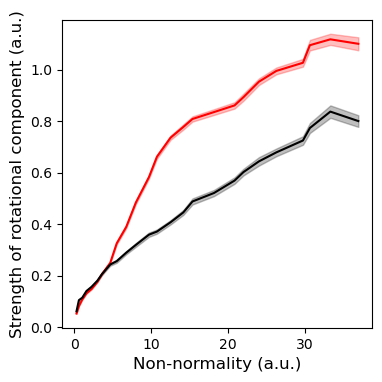

In [31]:
fig, ax =  plt.subplots(figsize=(4, 4))
ax.plot(nn/200, np.nanmean(jpca_eig[:, 0], axis=-1), color='r')
ax.fill_between(nn/200, np.nanmean(jpca_eig[:, 0], axis=-1) - 1/np.sqrt(200)*np.nanstd(jpca_eig[:, 0], axis=-1), np.nanmean(jpca_eig[:, 0], axis=-1) + 1/np.sqrt(200)*np.nanstd(jpca_eig[:, 0], axis=-1),
                color='r', alpha=0.25)
ax.plot(nn/200, np.nanmean(jpca_eig[:, 1], axis=-1), color='k')
ax.fill_between(nn/200, np.nanmean(jpca_eig[:, 1], axis=-1) - 1/np.sqrt(200)*np.nanstd(jpca_eig[:, 1], axis=-1), np.nanmean(jpca_eig[:, 1], axis=-1) + 1/np.sqrt(200)*np.nanstd(jpca_eig[:, 1], axis=-1),
                color='k', alpha=0.25)
ax.set_ylabel('Strength of rotational component' + ' (a.u.)', fontsize=12)
ax.set_xlabel('Non-normality (a.u.)', fontsize=12)
fig.savefig('/home/akumar/nse/neural_control/figs/synth/soc_jpca1.pdf', bbox_inches='tight', pad_inches=0)

In [21]:
def gen_activity(A, T, h):

    # f
    def f_(x, t):
        return A @ x

    # G: linear i.i.d noise with sigma
    def g_(x, t):
        return 0.25*np.eye(A.shape[0])

    # Generate random initial condition and then integrate over the desired time period
    tspace = np.linspace(0, T, int(T/h))
    
    x0 = np.ones(A.shape[0])

    return sdeint.itoSRI2(f_, g_, x0, tspace)    

In [22]:
# Plot trajectories from the systems towards the end of the curves
R = np.unique(df['R'].values)
# Get the A matrix associated with the 
df_ = apply_df_filters(df, R=R[20])
A = df_.iloc[0]['A']
d = 6
dt = 1

X = [gen_activity(A, 100, 1e-1) for _ in range(25)]
Pi = scipy.linalg.solve_continuous_lyapunov(A, -np.eye(A.shape[0]))
t_ = [j * dt for j in range(10)]
cross_covs = [scipy.linalg.expm(tau * A) @ Pi for tau in t_]

cross_covs_rev = [np.linalg.inv(cross_covs[0]) @ c.T @ np.linalg.inv(cross_covs[0]) for c in cross_covs]

cross_covs = torch.tensor(cross_covs)
cross_covs_rev = torch.tensor(cross_covs_rev)

e, Upca = np.linalg.eig(cross_covs[0])
eigorder = np.argsort(e)[::-1]
Upca = Upca[:, eigorder][:, 0:d]

lqgmodel = LQGCA(d=d, T=4, rng_or_seed=0)
lqgmodel.cross_covs = cross_covs
lqgmodel.cross_covs_rev = cross_covs_rev
# Simulate from the model, apply projection, and then fit jPCA

coef_, score = lqgmodel._fit_projection()

xfca = [x @ coef_ for x in X]
xpca = [x @ Upca for x in X]

/tmp/ipykernel_18625/504771196.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  cross_covs = torch.tensor(cross_covs)


In [23]:
from scipy.ndimage import gaussian_filter1d

In [24]:
xpca[0].shape

(1000, 6)

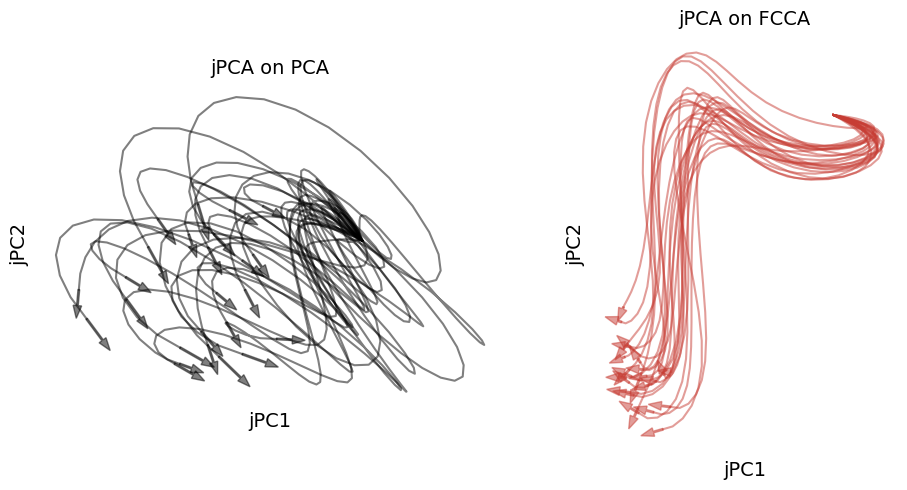

In [26]:
############## Trajectory Plots #################
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

for i in range(0, 25):
    
    trajectory = gaussian_filter1d(xpca[i][0:100, :], sigma=5, axis=0)[0:40]

    # Center and normalize trajectories
    trajectory -= trajectory[0]
    trajectory /= np.linalg.norm(trajectory)

    # Rotate trajectory so that the first 5 timesteps all go off at the same angle
    theta0 = np.arctan2(trajectory[5, 1], trajectory[5, 0])

    # Rotate *clockwise* by theta
    R = lambda theta: np.array([[np.cos(-1*theta), -np.sin(-theta)], \
                                    [np.sin(-theta), np.cos(theta)]])        
    #trajectory = np.array([R(theta0) @ t[0:2] for t in trajectory])

    ax[0].plot(trajectory[:, 0], trajectory[:, 1], 'k', alpha=0.5)
    ax[0].arrow(trajectory[-1, 0], trajectory[-1, 1], 
                trajectory[-1, 0] - trajectory[-2, 0], trajectory[-1, 1] - trajectory[-2, 1], 
                head_width=0.005, color="k", alpha=0.5)
    
    
    trajectory = gaussian_filter1d(xfca[i][0:100, :], sigma=5, axis=0)[0:40]

    # Center trajectories
    trajectory -= trajectory[0]
    trajectory /= np.linalg.norm(trajectory)

    # Rotate trajectory so that the first 5 timesteps all go off at the same angle
    theta0 = np.arctan2(trajectory[5, 1], trajectory[5, 0])

    #trajectory = np.array([R(theta0) @ t[0:2] for t in trajectory])

    ax[1].plot(trajectory[:, 0], trajectory[:, 1], '#c73d34', alpha=0.5)
    ax[1].arrow(trajectory[-1, 0], trajectory[-1, 1], 
                trajectory[-1, 0] - trajectory[-2, 0], trajectory[-1, 1] - trajectory[-2, 1], 
                head_width=0.005, color="#c73d34", alpha=0.5)

    ax[0].set_xticklabels([])
    ax[0].set_yticklabels([])
    
    ax[1].set_xticklabels([])
    ax[1].set_yticklabels([])
    
# ax[0].set_xlim([-0.3, 0.3])
# ax[1].set_xlim([-0.3, 0.3])

# ax[0].set_ylim([-0.3, 0.3])
# ax[1].set_ylim([-0.3, 0.3])

ax[0].set_aspect('equal')
ax[1].set_aspect('equal')

ax[0].set_title('jPCA on PCA', fontsize=14)
ax[0].set_ylabel('jPC2', fontsize=14)
ax[0].set_xlabel('jPC1', fontsize=14)

ax[1].set_title('jPCA on FCCA', fontsize=14)
ax[1].set_ylabel('jPC2', fontsize=14)
ax[1].set_xlabel('jPC1', fontsize=14)

ax[0].spines['right'].set_color('none')
ax[0].spines['top'].set_color('none')
ax[0].spines['left'].set_color('none')
ax[0].spines['bottom'].set_color('none')
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[1].spines['right'].set_color('none')
ax[1].spines['top'].set_color('none')
ax[1].spines['left'].set_color('none')
ax[1].spines['bottom'].set_color('none')
ax[1].set_xticks([])
ax[1].set_yticks([])
fig.tight_layout()
fig.savefig('/home/akumar/nse/neural_control/figs/synth/trajectories.pdf', bbox_inches='tight', pad_inches=0)

In [50]:
xpca[0].shape, 

(10000, 6)

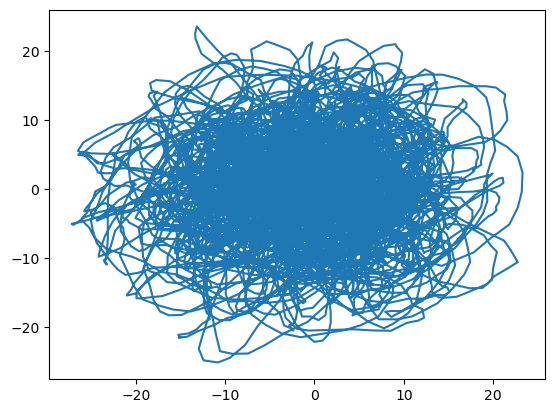

In [22]:
plt.plot(xpca[0][:, 0], xpca[0][:, 1])